In [32]:
import requests
from bs4 import BeautifulSoup
import tarfile
from io import BytesIO
from urllib.parse import urlparse
import os
import pandas as pd
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from unidecode import unidecode
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

### Download and extract tar files from the link provided

Link -> https://spamassassin.apache.org/old/publiccorpus/

In [6]:
# Function to get all links from a webpage
def get_all_links(url):
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find all 'a' tags (links) in the HTML
        links = soup.find_all('a')

        # Extract href attribute from each link
        all_links = [link.get('href') for link in links if link.get('href') is not None]
        tar_links = [link for link in all_links if 'tar.bz2' in link]
        return tar_links
    else:
        print(f"Failed to fetch URL. Status code: {response.status_code}")
        return []

In [15]:
# Function to download and extract tar files
def download_and_extract_tar(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        # Create a tarfile from the response content
        filename = os.path.basename(urlparse(url).path)

        # Create a directory with the same name as the tar file (without extension)
        directory_name = f"extracted_data/{os.path.splitext(filename)[0]}"
        os.makedirs(directory_name, exist_ok=True)

        # Create a tarfile from the response content
        tar_file = tarfile.open(fileobj=BytesIO(response.content), mode="r")

        # Extract the contents to the created directory
        tar_file.extractall(directory_name)
        print(f"Extracted contents from {url} to {directory_name}")
    else:
        print(f"Failed to download {url}. Status code: {response.status_code}")

In [16]:
# Example usage
url_to_scrape = "https://spamassassin.apache.org/old/publiccorpus/"
all_links_on_page = get_all_links(url_to_scrape)

# Print the extracted links
for link in all_links_on_page:
    print(link)
    download_and_extract_tar(f"https://spamassassin.apache.org/old/publiccorpus/{link}")

20021010_easy_ham.tar.bz2
Extracted contents from https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2 to extracted_data/20021010_easy_ham.tar
20021010_hard_ham.tar.bz2
Extracted contents from https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2 to extracted_data/20021010_hard_ham.tar
20021010_spam.tar.bz2
Extracted contents from https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2 to extracted_data/20021010_spam.tar
20030228_easy_ham.tar.bz2
Extracted contents from https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2 to extracted_data/20030228_easy_ham.tar
20030228_easy_ham_2.tar.bz2
Extracted contents from https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham_2.tar.bz2 to extracted_data/20030228_easy_ham_2.tar
20030228_hard_ham.tar.bz2
Extracted contents from https://spamassassin.apache.org/old/publiccorpus/20030228_hard_ham.tar.bz2 to extracted_data/20030228_hard_ham.tar
20030228_spam.ta

### Preprocessing

In [2]:
def get_all_files():
    ham_ls = []
    spam_ls = []
    parent_folder = "extracted_data"
    for sub_folder in os.listdir(parent_folder):
        fin_folder = os.listdir(f"{parent_folder}/{sub_folder}")[0]
        file_ls = [f"{parent_folder}/{sub_folder}/{fin_folder}/{file}" for file in os.listdir(f"{parent_folder}/{sub_folder}/{fin_folder}")]
        file_ls = [file for file in file_ls if "cmds" not in file]
        if 'ham' in fin_folder:
            ham_ls.extend(file_ls)
        else:
            spam_ls.extend(file_ls)
    return ham_ls, spam_ls

In [3]:
# This function removes lines which follow the format key: value
def remove_key_value_information(content):
    key_value_removed_ls = []
    for line in content.splitlines():
        if len(line.split(":")[0].split(" ")) != 1 and line.strip() != '':
            key_value_removed_ls.append(line)
    key_value_removed_str = '\n'.join(key_value_removed_ls)
    return key_value_removed_str

In [4]:
def extract_content_driver(file_ls):
    raw_content = []
    diff_ls = []
    for file in file_ls:
        try:
            with open(file,"r") as read_object:
                str_data = read_object.read()
            
            if "Content-Transfer-Encoding" in str_data:
                index = str_data.find("Content-Transfer-Encoding")
                content_after_keyword = str_data[index:]
                content = remove_key_value_information(content_after_keyword)
            elif "Content-Type" in str_data:
                index = str_data.find("Content-Type")
                content_after_keyword = str_data[index:]
                content = remove_key_value_information(content_after_keyword)
            elif "Date:" in str_data:
                index = str_data.find("Date:")
                content_after_keyword = str_data[index:]
                content = remove_key_value_information(content_after_keyword)
            raw_content.append(content)

        except:
            diff_ls.append(file)

    return raw_content

In [5]:
def merge_spam_and_ham_with_shuffling():
    ham_ls, spam_ls = get_all_files()
    raw_content = extract_content_driver(ham_ls)
    ham_df =pd.DataFrame(raw_content, columns=["Text"])
    ham_df['Class'] = 'Not Spam'

    raw_content = extract_content_driver(spam_ls)
    spam_df =pd.DataFrame(raw_content, columns=["Text"])
    spam_df['Class'] = 'Spam'

    result_df = pd.concat([ham_df, spam_df], ignore_index=True)
    shuffled_df = result_df.sample(frac = 1).reset_index(drop=True)
    return shuffled_df


In [6]:
def remove_urls(x):
    # Define a regex pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    result_string = url_pattern.sub('', x)
    return result_string

def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

def remove_html_tags(input_string):
    # Use BeautifulSoup to parse the HTML and extract text content
    soup = BeautifulSoup(input_string, 'html.parser')
    text_content = soup.get_text(separator=' ')
    return text_content

# def remove_html_tags(x):
# 	return BeautifulSoup(x, 'html.parser').get_text().strip()

# def remove_accented_chars(x):
# 	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
# 	return x

def remove_accented_characters(input_string):
    # Use unidecode to remove accented characters
    result_string = unidecode(input_string)
    return result_string

def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	


def perform_preprocessing(df):
	df['Text'] = df['Text'].apply(lambda x: remove_urls(x))
	# df['Text'] = df['Text'].apply(lambda x: remove_special_chars(x))
	df['Text'] = df['Text'].apply(lambda x: remove_html_tags(x))
	df['Text'] = df['Text'].apply(lambda x: remove_accented_characters(x))
	df['Text'] = df['Text'].apply(lambda x: remove_stopwords(x))
	return df
	

In [7]:
shuffled_df = merge_spam_and_ham_with_shuffling()
preprocessed_df = perform_preprocessing(shuffled_df)

C:\Users\Prithivee\AppData\Local\Temp\ipykernel_16320\2043530819.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(input_string, 'html.parser')


### Exploratory data analysis

- Target Class Distribution

In [37]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

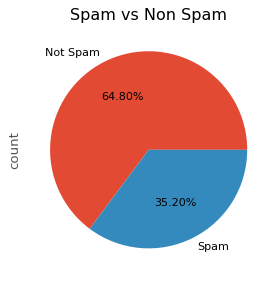

In [39]:
preprocessed_df['Class'].value_counts().plot.pie(autopct='%1.2f%%')

# Add a title to the pie chart
plt.title('Spam vs Not Spam')

# Display the plot
plt.show()

- Character and Word Distribution in Email

In [41]:
def get_wordcounts(x):
	length = len(str(x).split())
	return length

def get_charcounts(x):
	s = x.split()
	x = ''.join(s)
	return len(x)

temp_df = preprocessed_df.copy(deep=True)
temp_df['Character_Count'] = temp_df['Text'].apply(get_charcounts)
temp_df['Word_Count'] = temp_df['Text'].apply(get_wordcounts)

C:\Users\Prithivee\AppData\Local\Temp\ipykernel_16320\1508368177.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_df[temp_df['Class']=='Spam']['Character_Count'], shade=True, color='red',label='Spam')
C:\Users\Prithivee\AppData\Local\Temp\ipykernel_16320\1508368177.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_df[temp_df['Class']=='Not Spam']['Character_Count'], shade=True, color='blue',label='Not Spam')


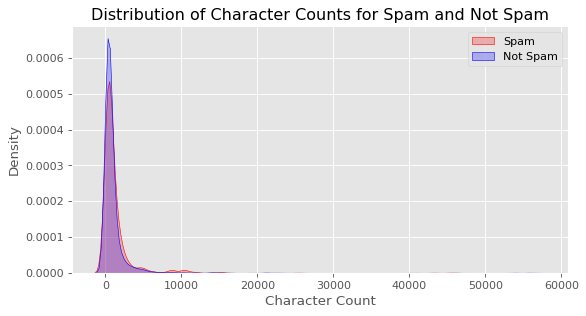

In [45]:
sns.kdeplot(temp_df[temp_df['Class']=='Spam']['Character_Count'], shade=True, color='red',label='Spam')
sns.kdeplot(temp_df[temp_df['Class']=='Not Spam']['Character_Count'], shade=True, color='blue',label='Not Spam')

plt.title('Distribution of Character Counts for Spam and Not Spam')
plt.xlabel('Character Count')
plt.ylabel('Density')

# Display legend
plt.legend()

# Show the plot
plt.show()

C:\Users\Prithivee\AppData\Local\Temp\ipykernel_16320\2908805993.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_df[temp_df['Class']=='Spam']['Word_Count'], shade=True, color='red',label='Spam')
C:\Users\Prithivee\AppData\Local\Temp\ipykernel_16320\2908805993.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(temp_df[temp_df['Class']=='Not Spam']['Word_Count'], shade=True, color='blue',label='Not Spam')


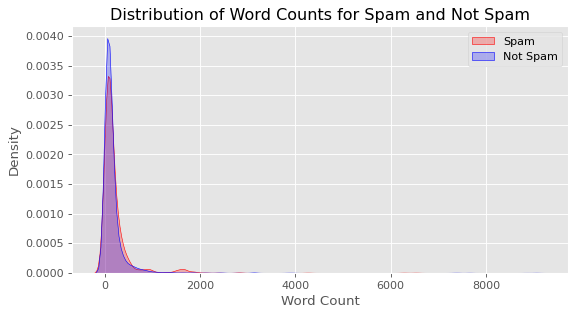

In [46]:
sns.kdeplot(temp_df[temp_df['Class']=='Spam']['Word_Count'], shade=True, color='red',label='Spam')
sns.kdeplot(temp_df[temp_df['Class']=='Not Spam']['Word_Count'], shade=True, color='blue',label='Not Spam')

plt.title('Distribution of Word Counts for Spam and Not Spam')
plt.xlabel('Word Count')
plt.ylabel('Density')

# Display legend
plt.legend()

# Show the plot
plt.show()

### Train Test Split

In [8]:
X_data =  preprocessed_df['Text']
y_data =  preprocessed_df['Class']

# Set the random_state for reproducibility
random_state_value = 42  # You can use any integer value as the random state

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state_value)

print("Train set shapes -> X: {}, y: {}".format(X_train.shape, y_train.shape))
print("Test set shapes -> X: {}, y: {}".format(X_test.shape, y_test.shape))

# Convert text data to feature vectors using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

Train set shapes -> X: (8581,), y: (8581,)
Test set shapes -> X: (2146,), y: (2146,)


### Model Training 

In [11]:
model_metadata_ls= []

- Naive Bayes

In [12]:
# Train the Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = naive_bayes_model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Naive Bayes")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

# Extract precision, recall, and F1-score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
model_metadata_ls.append({"Model":"Naive Bayes",
                           "Accuracy":round(accuracy, 2),
                           "Precision": round(precision,2),
                           "Recall": round(recall,2),
                           "F1 score": round(f1,2)
                           })

Naive Bayes
Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

    Not Spam       0.96      0.99      0.97      1430
        Spam       0.97      0.91      0.94       716

    accuracy                           0.96      2146
   macro avg       0.96      0.95      0.96      2146
weighted avg       0.96      0.96      0.96      2146



- SVM

In [16]:
# Define the SVM model
svm_model = SVC()

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],        # Regularization parameter
    'kernel': ['linear', 'rbf']  # Kernel type
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model using the best hyperparameters
grid_search.fit(X_train_vectorized, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Predict using the best model
y_pred = grid_search.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("SVM")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
model_metadata_ls.append({"Model":"SVM",
                           "Accuracy":round(accuracy, 2),
                           "Precision": round(precision,2),
                           "Recall": round(recall,2),
                           "F1 score": round(f1,2)
                           })


Best Hyperparameters: {'C': 0.1, 'kernel': 'linear'}
SVM
Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

    Not Spam       0.97      1.00      0.98      1430
        Spam       0.99      0.94      0.96       716

    accuracy                           0.98      2146
   macro avg       0.98      0.97      0.97      2146
weighted avg       0.98      0.98      0.98      2146



- Decision Trees

In [21]:
# Define the Decision Tree model
decision_tree_model = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],        # Criterion for splitting
    'max_depth': [None, 5, 10, 15],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]             # Minimum number of samples required to be at a leaf node
}

print("Decision Trees")
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model using the best hyperparameters
grid_search.fit(X_train_vectorized, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Predict using the best model
y_pred = grid_search.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)


precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
model_metadata_ls.append({"Model":"Decision Tree",
                           "Accuracy":round(accuracy, 2),
                           "Precision": round(precision,2),
                           "Recall": round(recall,2),
                           "F1 score": round(f1,2)
                           })


Decision Trees
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

    Not Spam       0.99      0.96      0.97      1430
        Spam       0.92      0.99      0.95       716

    accuracy                           0.97      2146
   macro avg       0.95      0.97      0.96      2146
weighted avg       0.97      0.97      0.97      2146



### Model Comparison

In [24]:
model_metadata_df = pd.DataFrame(model_metadata_ls)
model_metadata_df = model_metadata_df.sort_values(by='Accuracy', ascending=False)
model_metadata_df

,Model,Accuracy,Precision,Recall,F1 score
1,SVM,0.98,0.98,0.97,0.97
2,Decision Tree,0.97,0.95,0.97,0.96
0,Naive Bayes,0.96,0.96,0.95,0.96
